**Klassifikation**

Hilfsfunktionen & Einstellungen

In [1]:
# for pretty printing
import pprint as pp

# IPython (Jupyter) setting: 
# Print out every value instead of just "last_expr" (default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Warnungen unterdrücken
import warnings;
warnings.filterwarnings('ignore');

Daten mit get_poll_data aus DB laden.
Für spätere Klassifikation wird noch die Spalte Kategorie zum Dataframe hinzugefügt.

In [3]:
import sqlite3
import pandas as pd
import os.path
dbPath = "database/bachelor_umfrage.db"

def get_poll_data(table_name="selektierte_ergebnisse", where=None):
    df = pd.DataFrame()
    if os.path.isfile(dbPath):
        conn = sqlite3.connect(dbPath)
        sql = "SELECT * FROM " + table_name
        if where:
            sql += " WHERE " + where
        df = pd.read_sql_query(sql, conn)
    else:
        print("Datenbank oder Tabelle konnte nicht gefunden werden.")
    return df

def label_mint (row):
    if row['MINTFach'] == "ja" :
        return 'MINT'
    elif row['MINTFach'] == "nein" :
        return 'nicht_MINT'

poll_df = get_poll_data(table_name="selektierte_ergebnisse")
poll_df['category'] = poll_df.apply(label_mint, axis=1)
poll_df = poll_df.drop(columns=['Status'])
poll_df = poll_df.drop(columns=['AntwortID'])
poll_df.sample(5)

,Geschlecht,Studiengang,MINTFach,Qualifikation,GeborenAusland,ElternAusland,GeborenDeutschland,MINTStudiumEltern,StudiumEltern,MINTStudiumGeschwister,...,Gehalt,AnsehenGesellschaft,FamiliaereGründe,Partner,Kinder,Karriere,MINTGründe,NichtMINTGründe,Verbesserungsvorschläge,category
338,Weiblich,Soziale Arbeit: Erziehung und Bildung im Leben...,nein,beruflich qualifiziert,None,None,1,None,None,None,...,3,2,1,4,3,2,None,noch nie in Erwägung gezogen,nein,nicht_MINT
70,Weiblich,Design,nein,allgemeine Hochschulreife,None,None,1,None,None,None,...,3,3,2,3,3,4,None,None,None,nicht_MINT
256,Männlich,Bauingenieurwesen,ja,allgemeine Hochschulreife,None,None,1,1,None,None,...,4,3,3,4,4,2,None,None,None,MINT
94,Männlich,Bauingenieurwesen,ja,fachgebundene Hochschulreife,None,None,1,None,None,None,...,3,2,1,4,4,3,"ich wollte in nürnberg studieren, um pendeln z...",None,"leider nicht, , ich bin dazu so eingestellt, d...",MINT
67,Divers,Design,nein,allgemeine Hochschulreife,1,1,None,None,None,None,...,1,1,1,1,1,1,None,- Die traditionelle Ausrichtung des Studiums u...,Ja.,nicht_MINT


Verteilung MINT- und nicht MINT-Studenten: mehr MINT -> evtl. später ein Problem

category
MINT          430
nicht_MINT    279
Name: category, dtype: int64

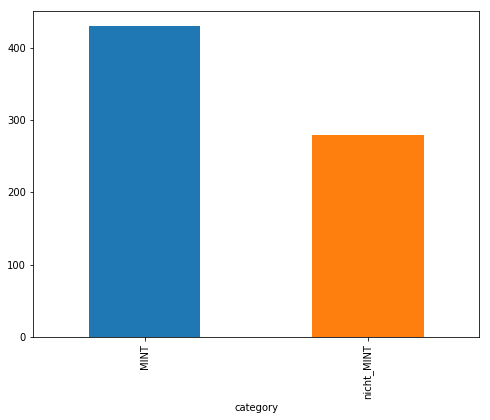

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
poll_df.groupby("category")["category"].count().plot.bar(ylim=0);
poll_df.groupby("category")["category"].count()

In [5]:
poll_df["category_id"] = poll_df["category"].factorize()[0]
category_id_df = poll_df[["category", "category_id"]].drop_duplicates().sort_values("category_id")
category_id_df

,category,category_id
0,nicht_MINT,0
1,MINT,1


None Werte durch 0 ersetzen.

In [17]:
poll_df['MINTStudiumEltern'] = poll_df['MINTStudiumEltern'].replace([None], [0], regex=True)
poll_df['StudiumEltern'] = poll_df['StudiumEltern'].replace([None], [0], regex=True)
poll_df['MINTStudiumGeschwister'] = poll_df['MINTStudiumGeschwister'].replace([None], [0], regex=True)
poll_df['StudiumGeschwister'] = poll_df['StudiumGeschwister'].replace([None], [0], regex=True)
poll_df['Studienpionier'] = poll_df['Studienpionier'].replace([None], [0], regex=True)
poll_df['MINTBerufEltern'] = poll_df['MINTBerufEltern'].replace([None], [0], regex=True)
poll_df['MINTBerufGeschwister'] = poll_df['MINTBerufGeschwister'].replace([None], [0], regex=True)
poll_df['KeinMINTBeruf'] = poll_df['KeinMINTBeruf'].replace([None], [0], regex=True)

Aufteilung der Daten in 80% Trainingsdaten & 20% Testdaten
- Datensätze: 709
- MINT: 430 => Training: 430 * 0,8 = 344, Test: 86
- Nicht MINT: 279 => Training: 279 * 0,8 = 223, Test: 56

In [43]:
from sklearn.model_selection import train_test_split
mint_df = poll_df.loc[poll_df['category'] == 'MINT']
mint_df["category_id"] = mint_df["category"].factorize()[0]
mint_labels = mint_df["category_id"]

nicht_mint_df = poll_df.loc[poll_df['category'] == 'nicht_MINT']
nicht_mint_df["category_id"] = nicht_mint_df["category"].factorize()[0]
nicht_mint_labels = nicht_mint_df["category_id"]

mint_features = mint_df.apply(lambda x:'%s_%s_%s_%s_%s_%s_%s_%s' 
                         % (x['MINTStudiumEltern'],x['StudiumEltern'],
                            x['MINTStudiumGeschwister'],x['StudiumGeschwister'],
                            x['Studienpionier'], x['MINTBerufEltern'],
                            x['MINTBerufGeschwister'], x['KeinMINTBeruf']),axis=1)

nicht_mint_features = nicht_mint_df.apply(lambda x:'%s_%s_%s_%s_%s_%s_%s_%s' 
                         % (x['MINTStudiumEltern'],x['StudiumEltern'],
                            x['MINTStudiumGeschwister'],x['StudiumGeschwister'],
                            x['Studienpionier'], x['MINTBerufEltern'],
                            x['MINTBerufGeschwister'], x['KeinMINTBeruf']),axis=1)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(mint_features, mint_labels, test_size=0.20)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(nicht_mint_features, nicht_mint_labels, test_size=0.20)

print("Mint:")
print(X_train_m.shape)
print(X_test_m.shape)
print(y_train_m.shape)
print(y_test_m.shape)
print("Nicht Mint:")
print(X_train_n.shape)
print(X_test_n.shape)
print(y_train_n.shape)
print(y_test_n.shape)
type(X_train_m)

X_train = X_train_m.append(X_train_n)
X_test = X_test_m.append(X_test_n)
y_train = y_train_m.append(y_train_n)
y_test = y_test_m.append(y_test_n)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
type(X_train)

Mint:
(344,)
(86,)
(344,)
(86,)
Nicht Mint:
(223,)
(56,)
(223,)
(56,)


pandas.core.series.Series

(567,)
(142,)
(567,)
(142,)


pandas.core.series.Series

In [16]:
#from sklearn.model_selection import train_test_split

#features = poll_df.apply(lambda x:'%s_%s_%s_%s_%s_%s_%s_%s' 
#                         % (x['MINTStudiumEltern'],x['StudiumEltern'],
#                            x['MINTStudiumGeschwister'],x['StudiumGeschwister'],
#                            x['Studienpionier'], x['MINTBerufEltern'],
#                            x['MINTBerufGeschwister'], x['KeinMINTBeruf']),axis=1)
#labels = poll_df["category_id"]

#X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

Trainieren des Naive Bayes Modells

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([("vect", CountVectorizer(ngram_range=(1, 1), stop_words=None)),
                     ("tfidf", TfidfTransformer(sublinear_tf=True, norm="l2")),
                     ("nb_clf", MultinomialNB()),])
text_clf = text_clf.fit(X_train, y_train)

In [20]:
%time text_clf.fit(X_train, y_train)

Wall time: 6.98 ms


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ear_tf=True, use_idf=True)), ('nb_clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Text(0.5, 0, 'True Values')

Text(0, 0.5, 'Predictions')

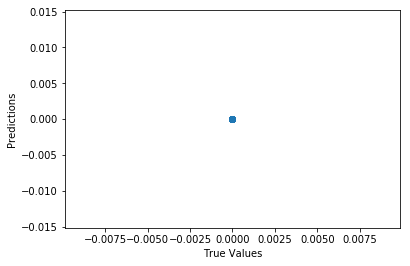

In [48]:
y_predicted = text_clf.predict(X_test)

plt.scatter(y_test, y_predicted)
plt.xlabel("True Values")
plt.ylabel("Predictions")

Berechnung Accuracy-Score

In [34]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_predicted)

1.0

Berechnung Classification Report

In [23]:
print(metrics.classification_report(y_test, y_predicted, 
                                    labels=category_id_df.category_id.values, 
                                    target_names=category_id_df.category.values))

              precision    recall  f1-score   support

  nicht_MINT       1.00      1.00      1.00       142
        MINT       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00       142
   macro avg       0.50      0.50      0.50       142
weighted avg       1.00      1.00      1.00       142



Confusion Matrix

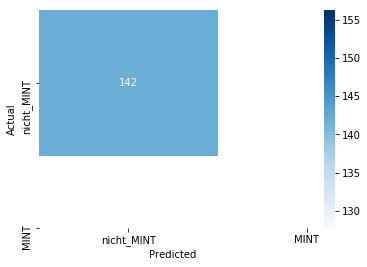

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_predicted)
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel("Actual")
plt.xlabel("Predicted");